In [1]:
import torch
import torch.nn as nn
# import os
import numpy as np
import math
import os
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.optim as optim 
import random

from sklearn.metrics import r2_score, explained_variance_score

# from ./networks/Network1 import Network1
# from networks.Network2 import Network2
from networks.Network3 import Network3

from matplotlib import pyplot as plt

### Data Preprocessing

In [2]:
def data_extractor(filename, processed_filename1, processed_filename2=None):
    # cleans IMU outputs and generates usable dataset as a clean CSV file

    file = open(filename, 'r')
    out_file1 = open(processed_filename1, 'w')
    if processed_filename2 is not None:
        out_file2 = open(processed_filename2, 'w')

    start_time, end_time, time  = '', '', ''
    lin_ctr = 0

    for l in file:
        if l[0] == '[':                              # if data has timestamp logging on
            time, line = l[10:22], l[24:].rstrip()
        else:
            line = l.rstrip()

        tab_ctr = line.count("\t")
        if tab_ctr == 3 or tab_ctr == 9:
            lin_ctr += 1
            line_lst = line.rstrip().split("\t")
            if line_lst[0]=='LSM_raw: ' :
                print(line.rstrip(), file=out_file1, end=";\t\t")
#             elif line_lst[0]=='MPU_raw: ' :
#                 print(line.rstrip(), file=out_file2, end=";\t\t")
            elif line_lst[0]=='LSM_ypr: ' :
                print(line.rstrip(), file=out_file1, end="\n")
#             elif line_lst[0]=='MPU_ypr: ' :
#                 print(line.rstrip(), file=out_file1, end="\n")
#                 print(line.rstrip(), file=out_file2, end="\n")
            if lin_ctr == 1 :
                start_time = time
            

    end_time = time
    if end_time != '':
        print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file1, end="\n")

    if (processed_filename2 is not None) and (end_time != ''):
        print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file2, end="\n")
        out_file2.close()

    out_file1.close()
    file.close()
    
def file_train_test_splitter(input_file_name, train_percent):
    # splits the input file into two files given by the train_percent
        # example usage : file_train_test_splitter("input.txt", 70)
    
    with open(input_file_name, 'r') as f:
        for i, l in enumerate(f):
            pass
    lines_in_file = i + 1   # total number of lines, aka, data points in the input file
    f.close()
    
    try:
        ratio = train_percent / 100
    except:
        print("Error: Invalid train test split ratio")
    
    num_train_data_points = int(lines_in_file * ratio)
    num_test_data_points = lines_in_file - num_train_data_points
    
    train_out_file = open(os.path.splitext(input_file_name)[0]+"_train_data.csv", 'w')
    test_out_file = open(os.path.splitext(input_file_name)[0]+"_test_data.csv", 'w')
    
    line_ctr = 0
    with open(input_file_name, 'r') as f:
        for line in f:
            line_ctr += 1
            line = line.rstrip()
            if line_ctr <= num_train_data_points:
                print(line, file = train_out_file)
            else:
                print(line, file = test_out_file)
    
    f.close()
    test_out_file.close()
    train_out_file.close()
    
    print("Train and test files created.")

In [3]:
# Data Pre-processing 
data_extractor("Datasets/LSM_rawtoypr_data.csv", "Datasets/LSM_rawtoypr_data_cleaned.csv")
file_train_test_splitter("Datasets/LSM_rawtoypr_data_cleaned.csv", 75)

Train and test files created.


### Deep Learning Network

In [4]:
model = Network3(init_weights=True)
print(model)

Network3(
  (conv1): Conv2d (1, 6, kernel_size=(5, 2), stride=(2, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (6, 20, kernel_size=(5, 2), stride=(2, 1))
  (batchnorm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (20, 30, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d (30, 40, kernel_size=(2, 2), stride=(2, 2))
  (batchnorm4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d (40, 50, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=50, out_features=20)
  (fc2): Linear(in_features=20, out_features=9)
  (fc3): Linear(in_features=9, out_features=3)
  (dp1): Dropout(p=0.5)
  (relu): ReLU(inplace)
)


### Data Loader class

In [5]:
class Data_loader(Dataset):
    # Loads data into the model

    def __init__(self, abs_filename, time_window=50, trans=False, sequential_test_mode=False):
        data, self.runtime = self.get_data(abs_filename)
        if self.runtime == 0:
            self.runtime = None
        try:
            self.data_matrix = data.reshape((1,data.shape[0], data.shape[1]))
            #print(self.data_matrix.shape)
        except IndexError:
            print("Data Error!: Data shape: ",data.shape)

        self.tw = time_window          # time window of samples
        
        self.rand_sel_lst = list(range(0,len(self))) 
        
        if(not sequential_test_mode):             # if you don't want the data to be loaded in the original order
            random.shuffle(self.rand_sel_lst)
        
        if(trans):
            self.transform_data()

    def get_data(self, abs_filename):
        # File specific parser for extracting sensor data
        file = open(abs_filename, 'r')
        run_time = 0                                    # program runtime (in seconds)
        data = []

        for line in file:

            #if line.count('\t') != 14:                  # skip line if data is not nominal
            #    continue

            if line[:10] == 'Start_time':
                run_time = self.get_runtime(line)
                continue

            line_lst = line.rstrip().split("\t")
            data_lst = line_lst[1:10] + line_lst[-3:]

            #if not self.isValidEntry(data_lst):         # skip line if data is not nominal
            #    continue

            if len(data_lst) == 12:
                data_lst[8] = data_lst[8][:-1]
                try :
                    for i in range(len(data_lst)):
                        data_lst[i] = float(data_lst[i])
                except ValueError:
                    continue
                data.append(data_lst)

        return np.array(data), run_time 
    
    def get_runtime(self, line):
        line_lst = line.rstrip().split(';')
        start_time, end_time = line_lst[0][-12:], line_lst[1][-12:]
        start_time, end_time = start_time.split(':'), end_time.split(':')
        lst = []
        for i in zip(start_time, end_time):
            a, b = float(i[0]), float(i[1])
            lst.append(b-a)
        return( 3600*lst[0] + 60*lst[1] + lst[2] )

    def __len__(self):
        # return math.ceil(self.data_matrix.shape[1] / self.tw)
        #return (self.data_matrix.shape[1] // self.tw)
        return (self.data_matrix.shape[1] - self.tw)

    def transform_data(self):
        trans = np.array([-1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1]).reshape((1,1,12)) # data specific transformation
        return self.data_matrix * trans


    def __getitem__(self,idx, ):        # idx ranges from 0 to len(self) 

        # if (idx+1)*self.tw > self.data_matrix.shape[1]:
        # 	d = self.data_matrix[:, idx*self.tw: , :]
        # else:
        i = self.rand_sel_lst[idx]
        #d = self.data_matrix[:, i*self.tw:(i+1)*self.tw , :]
        d = self.data_matrix[:, i:i+self.tw , :]

        return {'x': d[:, :, :9], 'y': d[:, -1:, 9:].squeeze() }

In [6]:
data_train = Data_loader("Datasets/LSM_rawtoypr_data_cleaned_train_data.csv")    # training data LSM raw -> LSM ypr
data_test = Data_loader("Datasets/LSM_rawtoypr_data_cleaned_test_data.csv") 

# yaw_dset_train_lpf98 = Data_loader("Datasets/360_yaw_lpf_98_data_cleaned.txt")     # training data LSM raw -> MPU ypr   
#yaw_dset_mpu_lpf98   = Data_loader("Datasets/mpu_360_yaw_lpf_98_data_cleaned.txt") # testing data MPU raw -> MPU ypr

In [7]:
print("Total training data samples = ", len(data_train))
print("Training Data matrix shape = ",data_train.data_matrix.shape)

print("Total test data samples = ", len(data_test))
print("Test Data matrix shape = ",data_test.data_matrix.shape)

Total training data samples =  5005
Training Data matrix shape =  (1, 5055, 12)
Total test data samples =  1636
Test Data matrix shape =  (1, 1686, 12)


#### Some pre training / testing initializations . . .

In [8]:
# a = torch.FloatTensor([179,5,6])
# b = torch.FloatTensor([-179,5,6])

# a = Variable(a, requires_grad=False)
# b = Variable(b, requires_grad=False)

# c = criterion(a,b)
# c
# #print(a,b,c)

# 90 % 180

# y = torch.FloatTensor(np.linspace(-180,180,500, endpoint=True))
# # y_hat = np.linspace(-180,180,500, endpoint=True)
# z = torch.mul((1 - torch.cos(y)), (1 - torch.cos(y)))
# z_n = np.array(z)

# plt.close()
# plt.figure(num=None, figsize=(18, 8), dpi=80)
# plt.plot(z_n)
# plt.show()
# print(round(min(z_n), 4))
# print(round(max(z_n),4))



In [9]:
# dset_train = Data_loader("MPU_MPL_LM4F_TM4C_uart/Datasets/misc_dataset_cleaned.txt", trans=True)
# print(dset_train.data_matrix[0])
# print("Shape of dataset = ", dset_train.data_matrix.shape)
# print("#Samples in dataset = ", len(dset_train))
# for i in range(len(dset_train)):
# 	print(dset_train.__getitem__(i)['x'].shape, dset_train.__getitem__(i)['y'].shape)

# Initializing the DataLoader(s)
dsets_enqueuer_training = torch.utils.data.DataLoader(data_train, batch_size=1, 
                                                      num_workers=1, drop_last=False)
dsets_enqueuer_testing = torch.utils.data.DataLoader(data_test, batch_size=1, 
                                                      num_workers=1, drop_last=False)


# Loss Function(s)
# criterion = nn.MSELoss()             # Mean Squared Error Loss (L2 Loss)
# criterion = nn.L1Loss()              # Mean Absolute Error Loss (L1 Loss)
# criterion = nn.SmoothL1Loss()        # Huber Loss 
criterion = lambda x, target: torch.mul((1 - torch.cos(target - x)), (1 - torch.cos(target - x)))

# Optimizer
optimizer = optim.Adam(model.parameters(),lr = 0.0001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = optim.Adagrad(model.parameters(), lr=0.0001, lr_decay=0, weight_decay=0)

if torch.cuda.is_available():
    criterion = criterion.cuda()

# Variables to keep track of losses 
loss_data_training = 0.0
loss_data_testing = 0.0

loss_lst_train = []
loss_lst_test = []

r_sq_lst = []
r_sq_lst_test = []

var_exp_lst = []
var_exp_lst_test = []

# # loss_lst_test = []

epochs = 100

### Main network Training / Testing routine

In [ ]:
print("\n\n\n[ Training Network ]\n")

for Epoch in range(epochs):
    
    y_per_epoch = []
    output_per_epoch = []

    #############################################################################################################
    #                                                  TRAINING                                                 #
    #############################################################################################################
    
    for idx, data in enumerate(dsets_enqueuer_training, 1):
        x,y = data['x'], data['y']

        if torch.cuda.is_available():
            x, y = Variable(x.cuda(), requires_grad = True).float(), Variable(y.cuda(), requires_grad = True).float()
        else:
            x, y = Variable(x, requires_grad = True).float(), Variable(y, requires_grad = True).float()

        # print(x.shape)
        # print(y.shape)
        
        # break
        
        model.train()
        output = model(x)

        # print(output.shape, type(output), output.data.numpy(), type(output.data.numpy()))
        # print(y.shape, type(y), y.data.numpy(), type(y.data.numpy()))

        optimizer.zero_grad()
        loss = criterion(output * np.pi/180 , y * np.pi/180)
        loss.backward(torch.Tensor([1, 1, 1]))
        optimizer.step()

        loss_data_training += loss.data
        
        y_per_epoch.append(y.data.numpy())
        output_per_epoch.append(output.data.numpy())

    R_sq_score = r2_score(np.squeeze(np.array(y_per_epoch)), 
                          np.squeeze(np.array(output_per_epoch))) 
    
    var_exp = explained_variance_score(np.squeeze(np.array(y_per_epoch)), 
                                       np.squeeze(np.array(output_per_epoch)))  

    if((Epoch+1) % 1 == 0):
        print ("Epoch \t{0} / {2} , \t loss = {1} , \t R^2 = {3} , \t Var exp = {4} %".format( Epoch+1, 
                                                                                     loss_data_training.cpu().numpy()/idx , 
                                                                                     epochs, 
                                                                                     round(R_sq_score, 4),
                                                                                     round(var_exp*100, 4) ))
#     print ("Epoch \t{0} / {2} , \t loss = {1} , \t R^2 = {3} ".format( Epoch+1, 
#                                                                         loss_data_training.cpu().numpy()/idx , 
#                                                                         epochs, 
#                                                                         round(R_sq_score, 3) ))
                                                                           

    loss_lst_train.append(loss_data_training.cpu().numpy()/idx)
    r_sq_lst.append(R_sq_score)
    var_exp_lst.append(var_exp)
    
    loss_data_training = 0.0
    
    y_per_epoch = []
    output_per_epoch = []
    
    #############################################################################################################
    #                                                  TESTING                                                  #
    #############################################################################################################
    
    
    for idx, data in enumerate(dsets_enqueuer_testing, 1):
        x,y = data['x'], data['y']
        
        if torch.cuda.is_available():
            x, y = Variable(x.cuda(), requires_grad = True).float(), Variable(y.cuda(), requires_grad = True).float()
        else:
            x, y = Variable(x, requires_grad = True).float(), Variable(y, requires_grad = True).float()

        model.eval()
        output = model(x)
        loss = criterion(output * np.pi/180 , y * np.pi/180 )
        loss_data_testing += loss.data
        
        y_per_epoch.append(y.data.numpy())
        output_per_epoch.append(output.data.numpy())
        
    R_sq_score = r2_score(np.squeeze(np.array(y_per_epoch)), 
                          np.squeeze(np.array(output_per_epoch))) 
    
    var_exp = explained_variance_score(np.squeeze(np.array(y_per_epoch)), 
                                       np.squeeze(np.array(output_per_epoch))) 
    
    loss_lst_test.append(loss_data_testing.cpu().numpy()/idx)
    r_sq_lst_test.append(R_sq_score)
    var_exp_lst_test.append(var_exp)
    loss_data_testing = 0.0
    
    if(Epoch > 0 and Epoch%10 == 0):                                     # Saving network weights every 10 Epochs
        model.save_checkpoint("/saved_model_weights/", Epoch)

    y_per_epoch = []
    output_per_epoch = []
        
        
print("\n\n[ Training Complete ]\n")      

print("\n\nMax training R squared value = ", max(r_sq_lst))
print("Max training variance explained = ", max(var_exp_lst))

print("\n\nMax testing R squared value = ", max(r_sq_lst_test))
print("Max testing variance explained = ", max(var_exp_lst_test))




[ Training Network ]

Epoch 	1 / 100 , 	 loss = [[0.91606355 0.03270401 0.17092215]] , 	 R^2 = -0.0596 , 	 Var exp = 4.0196 %
Epoch 	2 / 100 , 	 loss = [[0.40126276 0.03270406 0.16984288]] , 	 R^2 = -0.164 , 	 Var exp = 1.5028 %
Epoch 	3 / 100 , 	 loss = [[0.3576314  0.03270406 0.16980277]] , 	 R^2 = -0.2261 , 	 Var exp = -4.1544 %
Epoch 	4 / 100 , 	 loss = [[0.34471124 0.03270406 0.16980276]] , 	 R^2 = -0.2461 , 	 Var exp = -5.6521 %
Epoch 	5 / 100 , 	 loss = [[0.34202868 0.03270406 0.1697715 ]] , 	 R^2 = -0.2407 , 	 Var exp = -5.3784 %
Epoch 	6 / 100 , 	 loss = [[0.37549856 0.03270406 0.16976915]] , 	 R^2 = -0.1889 , 	 Var exp = -1.2737 %
Epoch 	7 / 100 , 	 loss = [[0.3987523  0.03270406 0.16975956]] , 	 R^2 = -0.1618 , 	 Var exp = 0.9757 %
Epoch 	8 / 100 , 	 loss = [[0.40453598 0.03270406 0.16976759]] , 	 R^2 = -0.1484 , 	 Var exp = 2.144 %
Epoch 	9 / 100 , 	 loss = [[0.43893665 0.03270406 0.16973175]] , 	 R^2 = -0.1115 , 	 Var exp = 5.6074 %
Epoch 	10 / 100 , 	 loss = [[0.455720

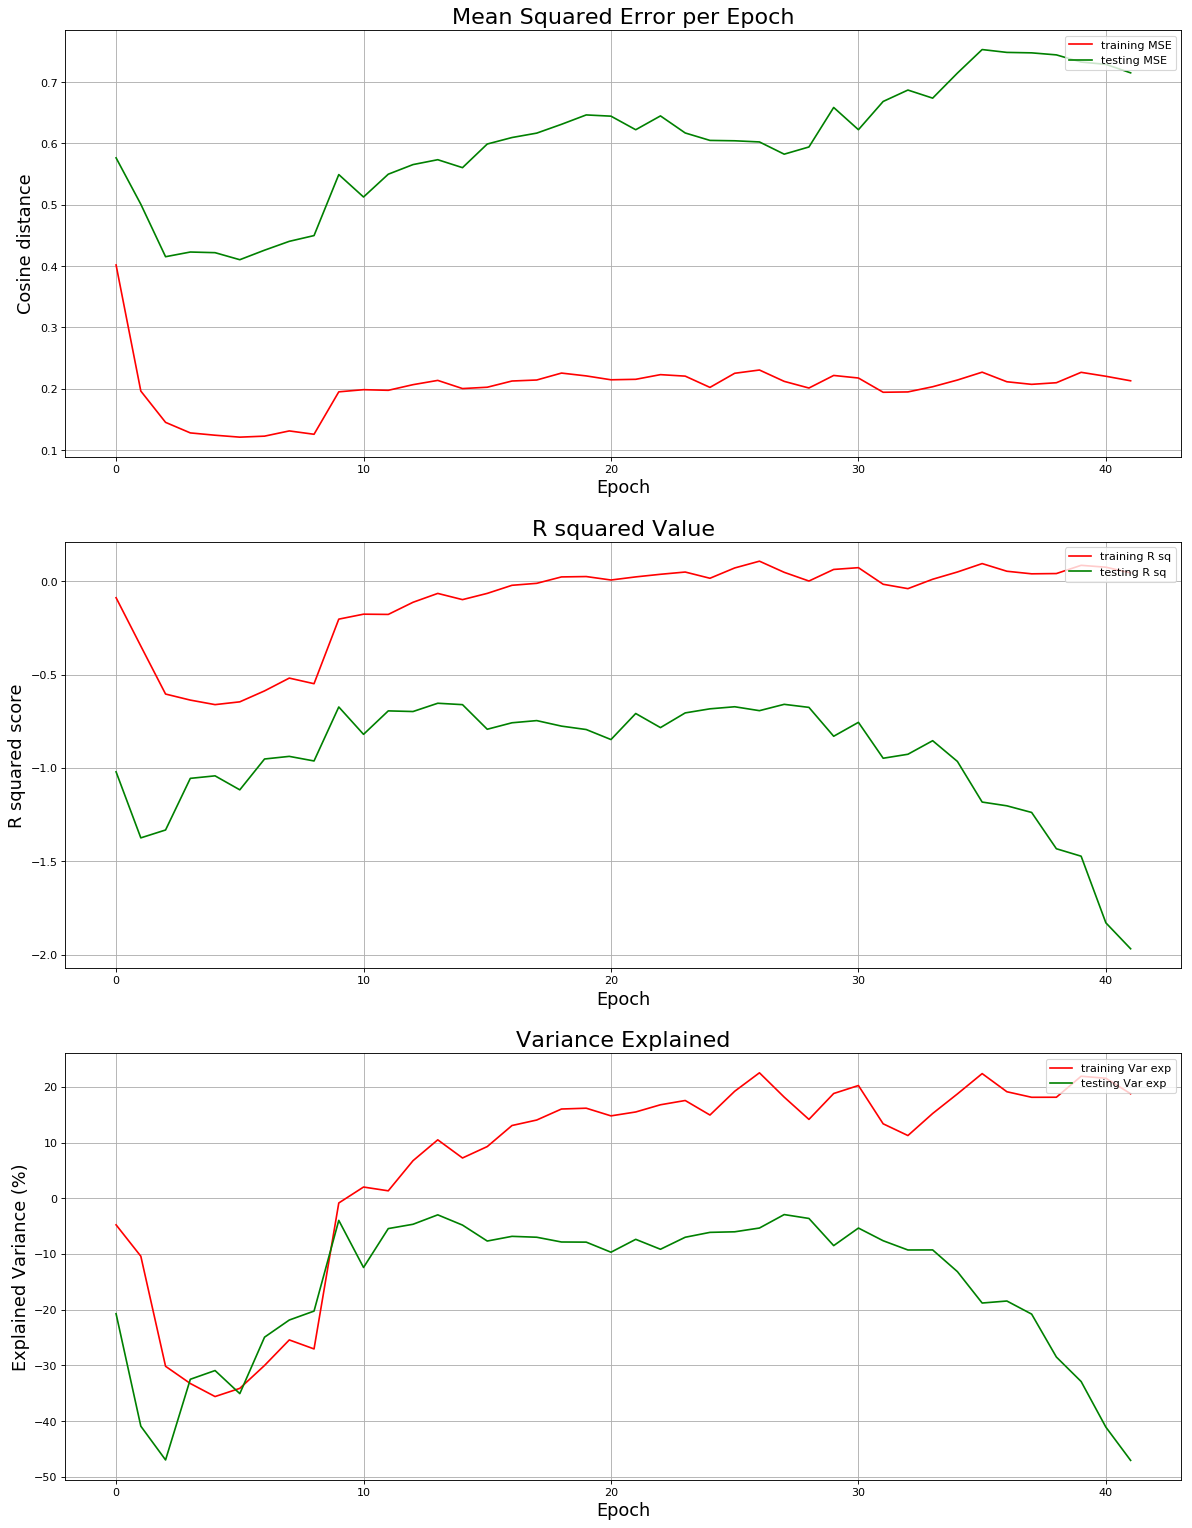

In [15]:
train_loss = np.squeeze(np.mean(np.array(loss_lst_train), axis=2))
test_loss = np.squeeze(np.mean(np.array(loss_lst_test), axis=2))

plt.close()
plt.figure(num=None, figsize=(18, 24), dpi=80)

plt.subplot(311)
plt.title('Mean Squared Error per Epoch', fontsize=20)
plt.plot( train_loss , 'r')            # this is the mean squared error among yaw, pitch, roll angles
plt.plot( test_loss  , 'g')            # can have a max value of 360^2 = 126000
# plt.plot( np.array(loss_lst_train) , 'r')            # this is the mean squared error among yaw, pitch, roll angles
# plt.plot( np.array(loss_lst_test)  , 'g')
plt.ylabel("Cosine distance", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.legend(['training MSE', 'testing MSE'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title("R squared Value", fontsize=20)
plt.plot(r_sq_lst, 'r')
plt.plot(r_sq_lst_test, 'g')
plt.ylabel("R squared score", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.legend(['training R sq', 'testing R sq'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title("Variance Explained", fontsize=20)
plt.plot(np.array(var_exp_lst) * 100, 'r')
plt.plot(np.array(var_exp_lst_test) * 100, 'g')
plt.ylabel("Explained Variance (%)", fontsize=16)
plt.xlabel("Epoch", fontsize=16)
plt.legend(['training Var exp', 'testing Var exp'], loc='upper right')
plt.grid()

plt.show()

### Loading Network weights that have the best testing loss

In [11]:
# state_dict = model.load_from_checkpoint("/saved_model_weights/network_state_checkpoint190.pth")
# model.load_state_dict(state_dict)

Loading model from 
/Users/crohan009/Documents/Stuff/USR18/code base/saved_model_weights/network_state_checkpoint190.pth 
...onto the CPU. 



In [22]:
data_test2 = Data_loader("Datasets/LSM_rawtoypr_data_cleaned_test_data.csv", sequential_test_mode=True)
dsets_enqueuer_trial = torch.utils.data.DataLoader(data_test2, batch_size=1, 
                                                      num_workers=1, drop_last=False)

y_lst = []
o_lst = []
data_ctr = 0

for idx, data in enumerate(dsets_enqueuer_trial, 1):
        x,y = data['x'], data['y']
        
        if torch.cuda.is_available():
            x, y = Variable(x.cuda(), requires_grad = False).float(), Variable(y.cuda(), requires_grad = False).float()
        else:
            x, y = Variable(x, requires_grad = False).float(), Variable(y, requires_grad = False).float()

        model.eval()
        output = model(x)
        
        y_lst.append(y)
        o_lst.append(output)
        data_ctr += 1
        if data_ctr >= 1000:
            break
        
# print("Model output \t= {} \ny \t\t= {}".format(np.squeeze(output.data.numpy()), 
#                                          np.squeeze(y.data.numpy())))
    

In [23]:
model_output = np.squeeze(np.array(o_lst))
expected = np.squeeze(np.array(y_lst))

yaw_out, yaw_exp     = model_output[:,0], expected[:,0]
pitch_out, pitch_exp = model_output[:,1], expected[:,1]
roll_out, roll_exp   = model_output[:,2], expected[:,2]

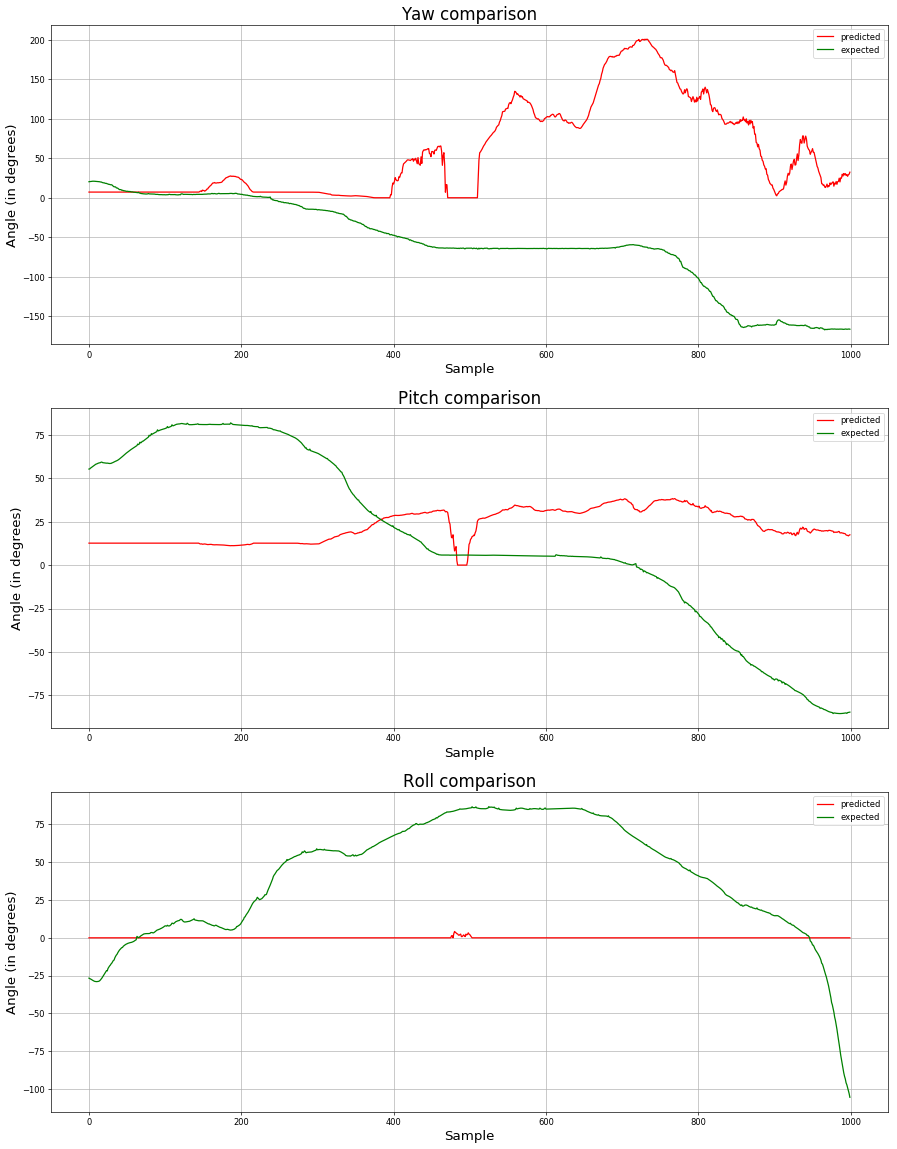

In [24]:
plt.close()
plt.figure(num=None, figsize=(18, 24), dpi=60)

plt.subplot(311)
plt.title('Yaw comparison', fontsize=20)
plt.plot( yaw_out , 'r')            # model output
plt.plot( yaw_exp  , 'g')            # expected output
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title('Pitch comparison', fontsize=20)
plt.plot( pitch_out , 'r')            # model output
plt.plot( pitch_exp  , 'g')            # expected output
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title('Roll comparison', fontsize=20)
plt.plot( roll_out , 'r')            # model output
plt.plot( roll_exp  , 'g')            # expected output
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("Sample", fontsize=16)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.show()